#### SHAP Parameter Importance Ranking  
by: Angel Moreno

Below I am defining the predictor variables and target variable for this analysis.

In [60]:
import pandas as pd
import numpy as np
import os
import warnings
from contextlib import redirect_stdout
import io
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
import shap
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# master data here
df_2017 = pd.read_csv("../finished_csvs/master_2017.csv")
df_2018 = pd.read_csv("../finished_csvs/master_2018.csv")
df_2019 = pd.read_csv("../finished_csvs/master_2019.csv")
df_2020 = pd.read_csv("../finished_csvs/master_2020.csv")
df_2021 = pd.read_csv("../finished_csvs/master_2021.csv")
df_2022 = pd.read_csv("../finished_csvs/master_2022.csv")
df_2023 = pd.read_csv("../finished_csvs/master_2023.csv")
df_2024 = pd.read_csv("../finished_csvs/master_2024.csv")

dfs = [df_2017, df_2018, df_2019, df_2020,
       df_2021, df_2022, df_2023, df_2024]

print(df_2017.columns)
print(f"This shape should be uniform across all dfs: {df_2017.shape}")

Index(['County', 'GEOID', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'Cases_2017',
       '2017_population', 'Cases_2017_normalized'],
      dtype='object')
This shape should be uniform across all dfs: (102, 69)


In [4]:
# these will be the same predictor variables for all 8 csv files (2017-2024)
# df_2017.columns[2:66]
predictors = ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']
# likewise, this will be the same target variable ('Cases_20XX_normalized')
# always at the end of the dfs
example_Y = df_2017.columns[-1]

print(predictors)
print('\n')
print(example_Y)

['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']


Cases_2017_normalized


#### CatBoost Model Performance

CatBoost is a gradient boosting based model that is excellent when there is a lot of categorical data. 

In [ ]:
# dfs_testing = [df_2017]
avg_rmse_scores_2017_2024 = []

# keep 5 for now but maybe increase if it runs somewhat fast
kfold = KFold(n_splits=5, shuffle=True, random_state = 27)

count = 0
year = 2017

for df in dfs:
  count += 1
  print(f"processing {count}/8")
  # only need to redefine Y var
  X = df[predictors]
  Y = df[df.columns[-1]]
  # https://catboost.ai/docs/en/concepts/parameter-tuning
  catboost = CatBoostRegressor(
    # default is 1000, but I will use 2000 since this is a smaller dataset
    iterations=2000,
    # depth 6 to 10 recommended
    depth=8,
    loss_function='RMSE',
    verbose=False,
    random_seed = 27
  )

  score = cross_val_score(catboost, X, Y, cv=kfold, scoring="neg_root_mean_squared_error")
  pos_score = -score
  avg_rmse_scores_2017_2024.append({
    "year":year,
    "rmse":pos_score.mean()
  })

  year += 1
# end of model validation

processing 1/8
processing 2/8
processing 3/8
processing 4/8
processing 5/8
processing 6/8
processing 7/8
processing 8/8


In [30]:
avg_rmse_scores_2017_2024

[{'year': 2017, 'rmse': np.float64(1.252681326251258)},
 {'year': 2018, 'rmse': np.float64(2.0558699845501422)},
 {'year': 2019, 'rmse': np.float64(1.295106391978416)},
 {'year': 2020, 'rmse': np.float64(0.2698741270348198)},
 {'year': 2021, 'rmse': np.float64(0.3082954710613737)},
 {'year': 2022, 'rmse': np.float64(0.36875699042322657)},
 {'year': 2023, 'rmse': np.float64(1.1491637791879044)},
 {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]

In [ ]:
# output:
# [{'year': 2017, 'rmse': np.float64(1.252681326251258)},
#  {'year': 2018, 'rmse': np.float64(2.0558699845501422)},
#  {'year': 2019, 'rmse': np.float64(1.295106391978416)},
#  {'year': 2020, 'rmse': np.float64(0.2698741270348198)},
#  {'year': 2021, 'rmse': np.float64(0.3082954710613737)},
#  {'year': 2022, 'rmse': np.float64(0.36875699042322657)},
#  {'year': 2023, 'rmse': np.float64(1.1491637791879044)},
#  {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]

#### TabNet Model Performance

TabNet is a deep learning model created for tabular data.

In [ ]:
def tabnet_cv_rmse(X, y, k=5):
  '''
  Ignore early stoppage and record avg rmse for ONE day only. 
  '''
  kfold = KFold(n_splits=k, shuffle=True, random_state=27)
  fold_rmses = []
  warnings.filterwarnings("ignore")

  # since tabnet does not support sklearn cross validation
  # we will manually compute rmse for each fold
  for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = TabNetRegressor(
      n_d=8, n_a=8, n_steps=3,
      gamma=1.5, lambda_sparse=1e-4,
      seed=27, verbose=0
    )

    # --- suppress TabNet's early stopping printouts ---
    # this is so I can actually record the best RMSE for each year and get the average
    f = io.StringIO()
    with redirect_stdout(f):
      model.fit(
        X_train.values,
        y_train.reshape(-1, 1),
        eval_set=[(X_test.values, y_test.reshape(-1, 1))],
        eval_metric=['rmse'],
        max_epochs=200,
        patience=20,
        batch_size=64,
        virtual_batch_size=32)

    preds = model.predict(X_test.values).reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    fold_rmses.append(rmse)

  # return avg 5 fold rmse for current year
  return np.mean(fold_rmses)

In [45]:
results = {}
dfs_testing = [df_2017]

year = 2017
for df in dfs:
  print(f"processing: {year}")
  X = df[predictors]
  y = df[df.columns[-1]].values
  avg_rmse = tabnet_cv_rmse(X, y)
  results[df.columns[-1]] = avg_rmse
  year += 1

processing: 2017
processing: 2018
processing: 2019
processing: 2020
processing: 2021
processing: 2022
processing: 2023
processing: 2024


In [46]:
results

{'Cases_2017_normalized': np.float64(1.0637535650384204),
 'Cases_2018_normalized': np.float64(1.815861333367744),
 'Cases_2019_normalized': np.float64(1.1135452653746047),
 'Cases_2020_normalized': np.float64(0.21372876809420177),
 'Cases_2021_normalized': np.float64(0.29463561869059474),
 'Cases_2022_normalized': np.float64(0.34777232804185193),
 'Cases_2023_normalized': np.float64(1.2375243289851097),
 'Cases_2024_normalized': np.float64(0.3293317663979392)}

Catboost and TabNet final results:

CatBoost 5-fold cross validation mean rmse for each year: 

[{'year': 2017, 'rmse': np.float64(1.252681326251258)},     
 {'year': 2018, 'rmse': np.float64(2.0558699845501422)},    
 {'year': 2019, 'rmse': np.float64(1.295106391978416)},   
 {'year': 2020, 'rmse': np.float64(0.2698741270348198)},    
 {'year': 2021, 'rmse': np.float64(0.3082954710613737)},    
 {'year': 2022, 'rmse': np.float64(0.36875699042322657)},   
 {'year': 2023, 'rmse': np.float64(1.1491637791879044)},    
 {'year': 2024, 'rmse': np.float64(0.33702369708109414)}]   


TabNet 5-fold cross validation mean rmse for each year: 

{'Cases_2017_normalized': np.float64(1.0637535650384204),   
 'Cases_2018_normalized': np.float64(1.815861333367744),    
 'Cases_2019_normalized': np.float64(1.1135452653746047),   
 'Cases_2020_normalized': np.float64(0.21372876809420177),    
 'Cases_2021_normalized': np.float64(0.29463561869059474),    
 'Cases_2022_normalized': np.float64(0.34777232804185193),    
 'Cases_2023_normalized': np.float64(1.2375243289851097),   
 'Cases_2024_normalized': np.float64(0.3293317663979392)}   

So in general, the performance is very similar between the two. CatBoost is better (lower RMSE values for a given year) in some years while TabNet is very close in performance most years. Overall, TabNet seems to be producing the lower RMSE overall. 

#### SHAP-TabNet Ranking for 2017-2024

Now that I have seen and recorded TabNet's performance against CatBoost, I will now produce the SHAP plots for 2017-2024.       
The plots will be beeswarm and  bar plots. 

training TabNet for 2017

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 0.95068
Plotting SHAP values for 2017


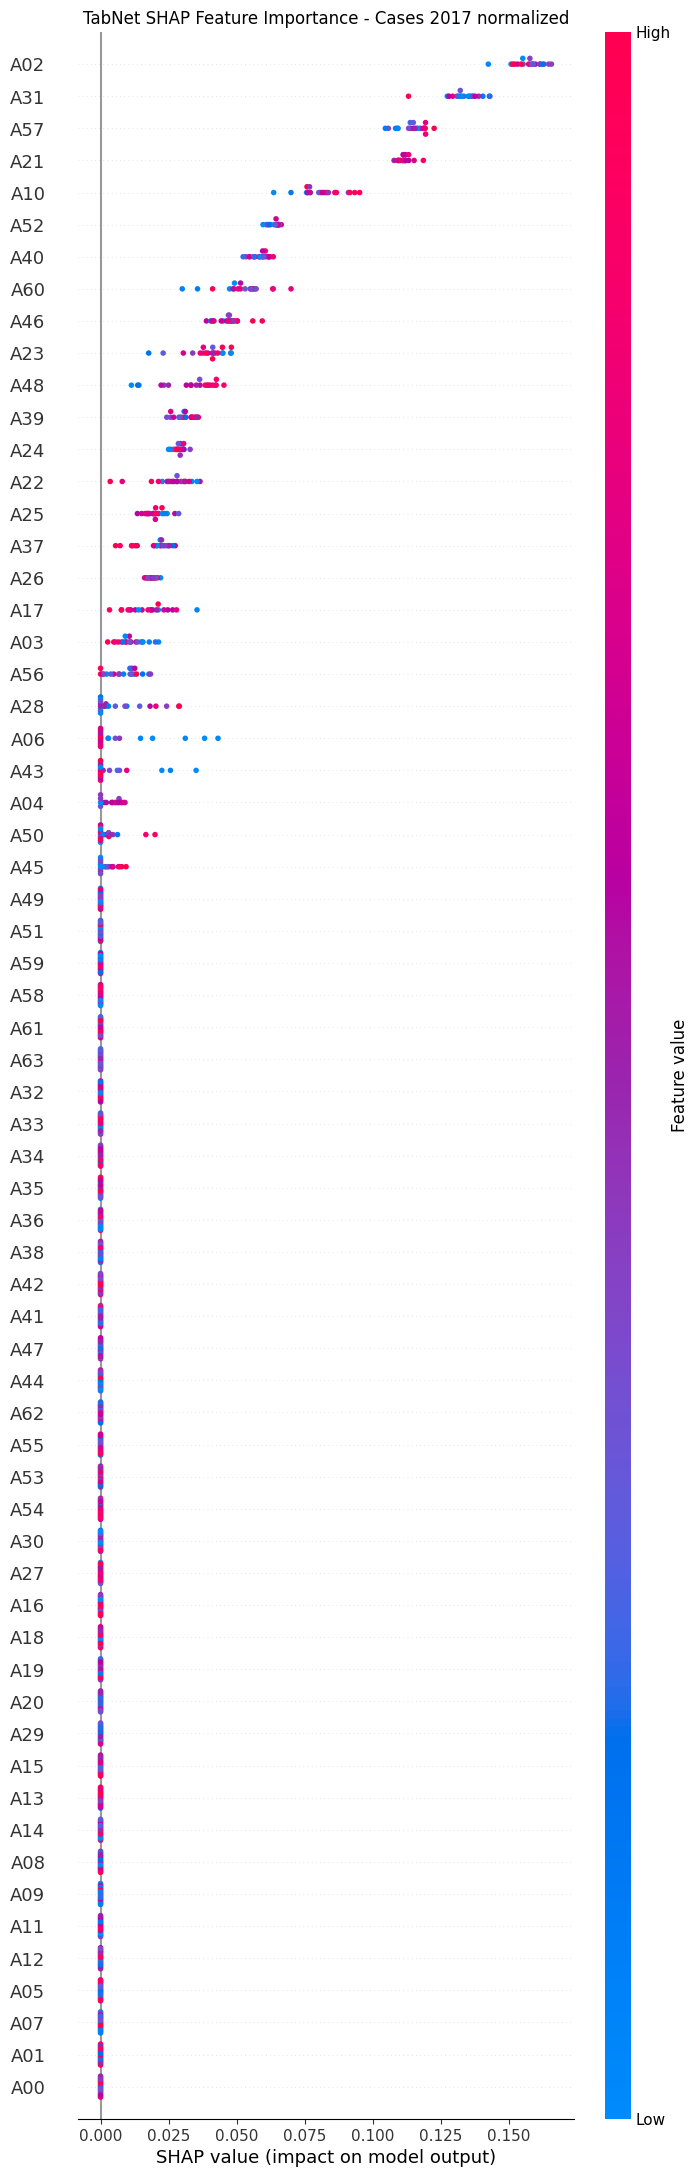

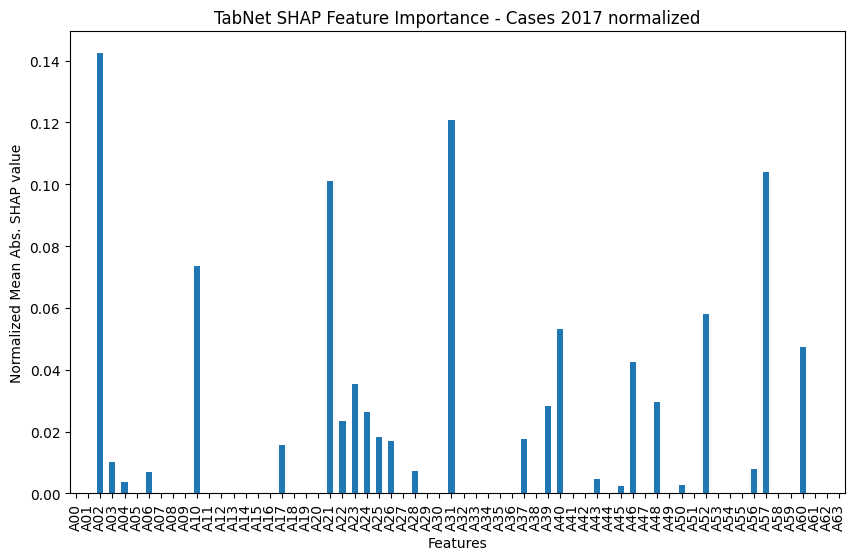

In [76]:
year = 2017
for df in dfs_testing:
    print(f"training TabNet for {year}")
    ##### same as cv section #####
    X = df[predictors]
    Y = df[df.columns[-1]]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

    model = TabNetRegressor(
        n_d=8, n_a=8, n_steps=3,
        gamma=1.5, lambda_sparse=1e-4,
        seed=27, verbose=0
    )

    model.fit(
        X_train.values,
        y_train.values.reshape(-1, 1),
        eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
        eval_metric=['rmse'],
        max_epochs=200,
        patience=20,
        batch_size=64,
        virtual_batch_size=32
    )
    ##### end training #####

    shap_values, masks = model.explain(X_test.values)

    mean_abs_shap = pd.Series(np.mean(np.abs(shap_values), axis=0), index=X_test.columns)
    shap_normalized = mean_abs_shap / mean_abs_shap.sum()
    # ignoring sorting for now
    # mean_abs_shap = mean_abs_shap.sort_values(ascending=False)

    print(f"Plotting SHAP values for {year}")

    # save path for the plots
    beeswarm_sumamry = f"../wnv_embeddings/shap_plots/beeswarm_plots/beeswarm_plot_for_{year}.png"
    # file_path_beeswarm = os.path.join(beeswarm_sumamry, f'beeswarm_plot_for_{year}.png')

    bar_plots = "../wnv_embeddings/shap_plots/bar_plots"
    file_path_bar = os.path.join(bar_plots, f'bar_plot_for_{year}.png')

    # first plot -> beeswarm plot for all 64 features 
    # note: beeswarm plots do not need normalization
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    shap_exp = shap.Explanation(values = shap_values, data = X_test.values, feature_names = X_test.columns)
    shap.plots.beeswarm(shap_exp, max_display=64)
    plt.show()
    # plt.savefig(beeswarm_sumamry)

    # second plot -> bar plot for all 64 features 
    plt.figure(figsize=(10,6))
    shap_normalized.plot(kind='bar')
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    plt.ylabel('Normalized Mean Abs. SHAP value')
    plt.xlabel('Features')
    plt.show()
    # plt.savefig(file_path_summary, dpi=300, bbox_inches="tight")

    year += 1